In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [ ]:
with open('/content/drive/My Drive/mnist-hw1.pkl', 'rb') as f:
  data = pkl.load(f)
  train, val = data['train'], data['test']
print(train.shape,val.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


In [ ]:
tf.test.is_gpu_available()

True

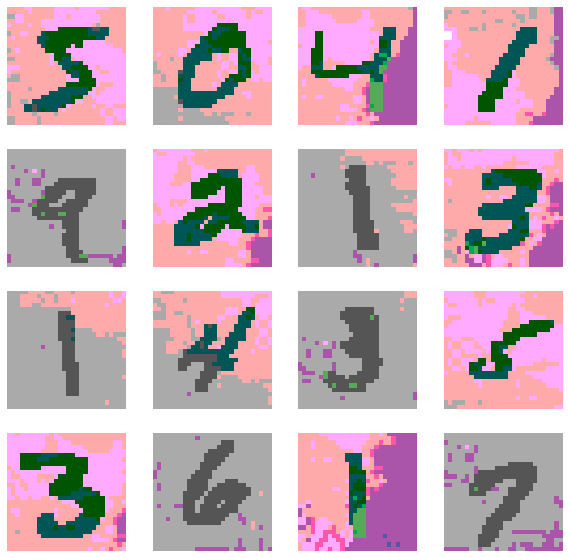

In [ ]:
def show_img(img):
    plt.figure(figsize=[10,10])
    img = np.asarray(img, dtype=np.float32)/np.max(img)
    for k in range(4):
        for l in range(4):
            plt.subplot(4, 4, 4 * k + l + 1)
            plt.imshow(img[4 * k + l])
            plt.axis('off')
            plt.grid(False)

show_img(train[:16])
plt.show()


In [ ]:
def sample_img( model, nrof_samples=16, inp_shape=(28,28,3), max_value=4):
  H, W, C = inp_shape
  img = np.zeros((nrof_samples, H, W, C), dtype=np.uint8)
  img[:, 0, 0, 0] = np.random.choice(max_value , size=(nrof_samples,))
  for i in range(H):
    for j in range(W):
      for c in range(C):
        if len(model)>1:
          L , p = model[0].loss(img, model[1])
        else:
          L , p = model[0].loss(img)
        p = tf.cast(p, tf.float64)
        p = tf.truediv(p, tf.reduce_sum(p, axis=-1, keepdims=True))  
        for k in range(nrof_samples):
           img[k, i, j, c] = np.random.choice(max_value, p=p[k,i,j,c])
  return img
      

In [ ]:
class pixelcnn(object):
  def __init__(self, inp_shape =(28,28,3), nrof_res_blocks=12, color_dims=4):
    self.nrof_res_blocks = nrof_res_blocks
    self.color_dims = color_dims
    self.inp_shape = inp_shape
    self.nrof_filters=64
    self.var=[]
    self.mask = []
    self.m=0
    self.idx = 0
    self.initializer = tf.initializers.GlorotUniform()
  

  def masked_conv_w(self,C , out_dim, f_size, mtype='a'):
    fh, fw = f_size
    mask = np.zeros((fh, fw, C , out_dim))
    mask[fh//2,:fw//2,:,:] = 1.
    mask[:fh//2, :, :, :] = 1. 
    if mtype == 'b' :
      mask[fh//2, fw//2,:,:] = 1.
    
    self.var += [tf.Variable(self.initializer((fh, fw, C, out_dim)))]
    self.var += [tf.Variable(tf.zeros((self.inp_shape[0], self.inp_shape[1], out_dim)))]
    self.mask+= [mask]
  
  def init_weights(self):
    out_dim=self.nrof_filters
    _ =self.masked_conv_w(3 , out_dim*2, [7,7])
    for i in range(self.nrof_res_blocks):
      self.masked_conv_w(out_dim*2 ,out_dim , [1,1], mtype='b')
      self.masked_conv_w(out_dim ,out_dim , [3,3], mtype='b')
      self.masked_conv_w(out_dim ,out_dim*2 , [1,1], mtype='b')
    self.masked_conv_w(out_dim*2 ,out_dim , [3,3], mtype='b')
    self.masked_conv_w(out_dim ,out_dim , [1,1], mtype='b')
    self.masked_conv_w(out_dim ,self.color_dims*3 , [1,1], mtype='b')

  def residual_block(self, inp):
    nn = tf.nn.relu(inp)
    nn = tf.nn.conv2d(input= nn, filters= self.var[self.idx]*self.mask[self.m],strides=[1,1] , padding='SAME')+self.var[self.idx+1]
    self.idx+=2
    self.m+=1
    nn = tf.nn.relu(nn)
    nn = nn = tf.nn.conv2d(input= nn, filters= self.var[self.idx]*self.mask[self.m] ,strides=[1,1] , padding='SAME')+self.var[self.idx+1]
    self.idx+=2
    self.m+=1
    nn = tf.nn.relu(nn)
    nn = tf.nn.conv2d(input= nn, filters= self.var[self.idx]*self.mask[self.m] ,strides=[1,1] , padding='SAME')+self.var[self.idx+1]
    self.idx+=2
    self.m+=1
    return nn+inp
  
  def forward(self, x ):
    inp = tf.cast(x, tf.int8)
    x = tf.cast(x, tf.float32)
    x = tf.multiply(x, 1/tf.reduce_max(x))
    x = tf.nn.conv2d(input= x, filters= self.var[self.idx]*self.mask[self.m] ,strides=[1,1] , padding='SAME')+self.var[self.idx+1]
    self.idx+=2
    self.m+=1
    for i in range(self.nrof_res_blocks):
      x = self.residual_block(x)
    x = tf.nn.conv2d(input= x, filters= self.var[self.idx]*self.mask[self.m] ,strides=[1,1] , padding='SAME')+self.var[self.idx+1]
    self.idx+=2
    self.m+=1
    x = tf.nn.relu(x)
    x = tf.nn.conv2d(input= x, filters= self.var[self.idx]*self.mask[self.m] ,strides=[1,1] , padding='SAME')+self.var[self.idx+1]
    self.idx+=2
    self.m+=1
    x = tf.nn.relu(x)
    x = tf.nn.conv2d(input= x, filters= self.var[self.idx]*self.mask[self.m] ,strides=[1,1] , padding='SAME')+self.var[self.idx+1]
    self.idx=0
    self.m=0
    return x
 
  def loss(self, inp):
    N, H, W, C = inp.shape
    x= self.forward(inp)
    logits = tf.reshape(x, (-1, H, W, C, self.color_dims))
    p = tf.nn.softmax(logits)
    inp = tf.cast(inp, tf.int32)
    loss =  tf.nn.sparse_softmax_cross_entropy_with_logits(labels=inp, logits=logits)
    loss = tf.math.reduce_mean(loss)/ tf.math.log(2.) 
    return loss, p


In [ ]:
batch_size = 127
lr =1e-3
num_epochs =10
opt = tf.optimizers.RMSprop(learning_rate=lr , decay=0.1)
pcnn = pixelcnn()
pcnn.init_weights()

trn_loss, val_loss = [],[]
for epoch in range(num_epochs):
  
    batch_loss =[]
    for  step, batch in enumerate(np.array_split(train, train.shape[0]//batch_size)):
      with tf.GradientTape() as tape:
        loss, _ = pcnn.loss(batch)
      batch_loss.append(loss)
      gradients = tape.gradient(loss, pcnn.var)
      opt.apply_gradients(zip(gradients, pcnn.var))
      if step % 50 == 0:
        print('batch: {}  Train loss: {} '.format(step, batch_loss[-1]))
    np.random.shuffle(train)              
    if epoch % 1 == 0:
      trn_loss.append(tf.math.reduce_mean(batch_loss))
      vloss =[]
      for vx in np.array_split(val, batch_size):
         vl,_ = pcnn.loss(vx)
         vloss.append(vl)
      vloss = tf.math.reduce_mean(vloss)
      val_loss.append(vloss)
      print('Epoch: {}  Train loss: {}  Validation Loss: {} '.format(epoch, trn_loss[-1], val_loss[-1]))
 

batch: 0  Train loss: 2.0052459239959717 
batch: 50  Train loss: 0.8853416442871094 
batch: 100  Train loss: 0.7049593925476074 
batch: 150  Train loss: 0.608596682548523 
batch: 200  Train loss: 0.5939251780509949 
batch: 250  Train loss: 0.5357925295829773 
batch: 300  Train loss: 0.5193167924880981 
batch: 350  Train loss: 0.5539398193359375 
batch: 400  Train loss: 0.5035418272018433 
batch: 450  Train loss: 0.49169430136680603 
Epoch: 0  Train loss: 0.6467936635017395  Validation Loss: 0.4919460117816925 
batch: 0  Train loss: 0.4923666715621948 
batch: 50  Train loss: 0.4796335697174072 
batch: 100  Train loss: 0.4606592357158661 
batch: 150  Train loss: 0.47167569398880005 
batch: 200  Train loss: 0.4720342457294464 
batch: 250  Train loss: 0.45294734835624695 
batch: 300  Train loss: 0.45326998829841614 
batch: 350  Train loss: 0.45080792903900146 
batch: 400  Train loss: 0.4558406472206116 
batch: 450  Train loss: 0.4618098735809326 
Epoch: 1  Train loss: 0.470065176486969  Va

KeyboardInterrupt: ignored

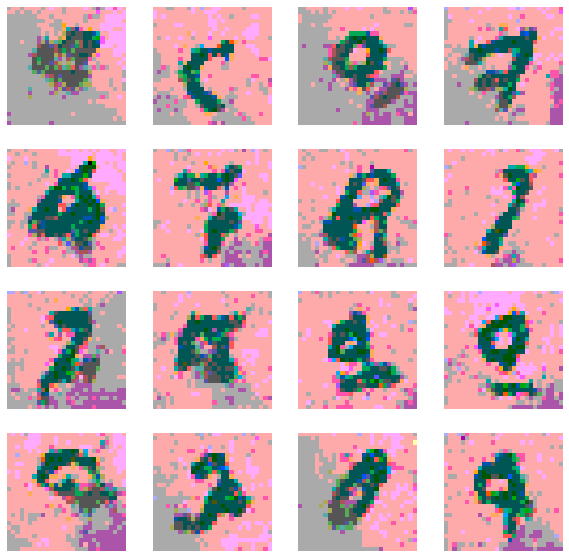

In [ ]:
img = sample_img([pcnn])
show_img(img)
plt.show()

In [ ]:
class made(object):
  
  def __init__(self, inp_shape=24, nrof_aux= 4*3 , nrof_dims=3 , nrof_bins=4, nrof_layers=2 , nrof_units=[128, 128, 12] ):
    self.naux = nrof_aux
    self.dims = nrof_dims
    self.units= nrof_units
    self.no_layers = nrof_layers
    self.bins = nrof_bins
    self.inp_shape = inp_shape
    self.initializer = tf.initializers.GlorotUniform()
    self.var = []
    self.idx=0


  def init_weights(self):
    inp = self.inp_shape
    for i in range(self.no_layers+1):
      self.var.append(tf.Variable(self.initializer((inp, self.units[i]))))
      self.var.append(tf.Variable(tf.zeros((self.units[i]))))
      inp = self.units[i] + self.naux

  
  def get_masks(self, nrof_units=128, nrof_layers=2, nrof_dims=3, nrof_aux=4*3, nrof_bins=4):
    m = []
    m0 = np.repeat(np.arange(nrof_dims), nrof_bins)
    m += [ m0 ]
    for i in range(nrof_layers):
        rep = int(np.ceil(nrof_units/((nrof_dims-1))))
        mx = np.repeat(np.arange(nrof_dims-1), rep)[:nrof_units]
        m += [ mx ]
        
    mask = []
    for i in range(len(m)-1):
        msk = m[i+1][:,None] >= m[i][None,:]
        cx = np.ones((msk.shape[0], nrof_aux))
        msk2 = np.concatenate((cx, msk), axis=1)
        mask += [ msk2.T ]
    msk = m0[:,None] > m[-1][None,:]
    cx = np.ones((msk.shape[0], nrof_aux))
    msk2 = np.concatenate((cx, msk), axis=1)
    mask += [ msk2.T ]
        
    return mask
  
  def forward(self, inp, pcnn):
    aux = pcnn.forward(inp)
    inp = tf.one_hot(inp, 4)
    x = tf.cast(inp, tf.float32)
    x = tf.multiply(x, 1/3.)
    aux = tf.reshape(aux, (-1, 4*3))
    x = tf.reshape( x, (-1, 4*3))
    mask = self.get_masks()
    for i in range(self.no_layers+1):
      x = tf.concat([aux , x ], axis=-1)
      x = tf.tensordot(x, self.var[self.idx]*mask[i],1)+ self.var[self.idx+1]
      if i < self.no_layers:
        x = tf.nn.relu(x)
      self.idx+=2
    x = tf.reshape(x, (-1, 28,28,3,4))
    self.idx=0
    return x

  def loss(self, inp, pcnn):
    y = self.forward(inp, pcnn)
    inp = tf.cast(inp, tf.int32)
    loss =  tf.nn.sparse_softmax_cross_entropy_with_logits(labels=inp, logits=y)
    loss = tf.math.reduce_mean(loss)/ tf.math.log(2.)
    p = tf.nn.softmax(y, axis=-1)
    return loss, p 
    

In [ ]:
batch_size = 127
lr =1e-4
num_epochs =15
opt = tf.optimizers.RMSprop(learning_rate=lr )
made = made()
made.init_weights()
var = pcnn.var + made.var
trn_loss, val_loss = [],[]
for epoch in range(num_epochs):
  
    batch_loss =[]
    for  step, batch in enumerate(np.array_split(train, train.shape[0]//batch_size)):
      with tf.GradientTape() as tape:
        loss, _ = made.loss(batch, pcnn)
      batch_loss.append(loss)
      gradients = tape.gradient(loss, var)
      opt.apply_gradients(zip(gradients, var))
      if step % 50 == 0:
        print('batch: {}  Train loss: {} '.format(step, batch_loss[-1]))
    np.random.shuffle(train)              
    if epoch % 1 == 0:
      #img = sample_img([pcnn])
      #show_img(img)
      #plt.show()
      trn_loss.append(tf.math.reduce_mean(batch_loss))
      vloss =[]
      for vx in np.array_split(val, batch_size):
         vl,_ = made.loss(vx, pcnn)
         vloss.append(vl)
      vloss = tf.math.reduce_mean(vloss)
      val_loss.append(vloss)
      print('Epoch: {}  Train loss: {}  Validation Loss: {} '.format(epoch, trn_loss[-1], val_loss[-1]))
 

batch: 0  Train loss: 2.9509365558624268 
batch: 50  Train loss: 0.5521051287651062 
batch: 100  Train loss: 0.44519615173339844 
batch: 150  Train loss: 0.39668330550193787 
batch: 200  Train loss: 0.3774743676185608 
batch: 250  Train loss: 0.3902924060821533 
batch: 300  Train loss: 0.35367152094841003 
batch: 350  Train loss: 0.37256231904029846 
batch: 400  Train loss: 0.3670614957809448 
batch: 450  Train loss: 0.34246858954429626 
Epoch: 0  Train loss: 0.43983012437820435  Validation Loss: 0.33478161692619324 
batch: 0  Train loss: 0.33871233463287354 
batch: 50  Train loss: 0.3528631031513214 
batch: 100  Train loss: 0.3507671058177948 
batch: 150  Train loss: 0.33357539772987366 
batch: 200  Train loss: 0.3413354158401489 
batch: 250  Train loss: 0.363056480884552 
batch: 300  Train loss: 0.39207184314727783 
batch: 350  Train loss: 0.3790804147720337 
batch: 400  Train loss: 0.317699670791626 
batch: 450  Train loss: 0.3322567939758301 
Epoch: 1  Train loss: 0.337790459394454

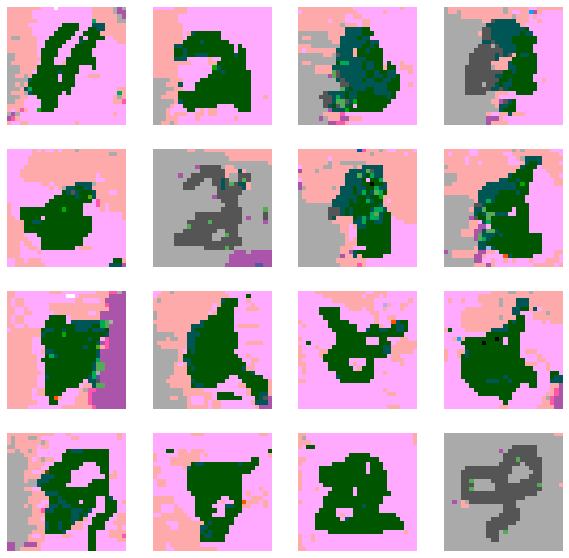

In [ ]:
img = sample_img([made,pcnn])
show_img(img)
plt.show()